# Creating Dataset

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

In [17]:
def out_plots(gt, pred):
    gt = gt.detach().numpy()
    pred = pred.detach().numpy()
    
    fig, ax = plt.subplots(nrows=1, ncols=2)

    plt.subplot(1,2,1)
    for i, trajectory in enumerate(gt):
        x = trajectory[:, 0]  # Extract x positions
        y = trajectory[:, 1]  # Extract y positions
        plt.title("ground_truth_trajectories")
        plt.legend()
        plt.grid(True)
        plt.plot(x, y)

    plt.subplot(1,2,2)
    for i, trajectory in enumerate(pred):
        x = trajectory[:, 0]  # Extract x positions
        y = trajectory[:, 1]  # Extract y positions
        plt.title("Predicted_trajectories")
        plt.legend()
        plt.grid(True)
        plt.plot(x, y)
    
    plt.show()

In [18]:
def generate_trajectory(speed, steering_angle):
  # Initialize state variables
  x = 0.0  # initial x position
  y = 0.0  # initial y position
  theta = 0.0  # initial heading direction (facing along the x-axis)

  L = 2.5  # wheelbase of the vehicle (distance between front and rear axle)

  # Simulation settings
  dt = 0.1  # time step in seconds
  total_time = 2
  # Number of timesteps (excluding the last one for consistency)
  num_steps = int(total_time / dt)

  # Initialize a single NumPy array to store (x, y) pairs
  trajectory = np.zeros((num_steps, 2))

  thet = np.deg2rad(steering_angle)

  # Simulation loop
  for i in range(num_steps):
    # Update the vehicle's state
    x += speed * np.cos(theta) * dt
    y += speed * np.sin(theta) * dt
    theta += speed * np.tan(thet) / L * dt

    # Store positions in the trajectory array
    trajectory[i, 0] = x
    trajectory[i, 1] = y

  return trajectory

def generate_data(speed):
    angles = np.arange(-10, 10, 4)
    all_trajs = []
    for angle in angles:
        trajectory = generate_trajectory(speed,angle)
        all_trajs.append(trajectory)
    return speed, all_trajs

def save_trajectories(x = 0, y = 50, z = 1):
    speeds = np.arange(x, y , z)
    all_data = {"state" : [], "trajectory" : []}
    for current_speed in speeds:
        speed, all_trajs = generate_data(current_speed)
        state = np.array([0,0,current_speed,1])
        all_data["state"].append(state)
        all_data["trajectory"].append(all_trajs)
    return all_data

def process_data(data):
    states = []
    trajectories = []

    for state, trajs in zip(data["state"], data["trajectory"]):
        states.append(state)
        trajectories.append(trajs)
    
    return np.array(states), np.array(trajectories)

In [19]:
output = save_trajectories(1,40,0.1)
speeds, trajectories = process_data(output)

In [20]:
class TrajectoryDataset(Dataset):
    def __init__(self, speeds, trajectories):
        self.speeds = speeds
        self.trajectories = trajectories

    def __len__(self):
        return len(self.speeds)

    def __getitem__(self, idx):
        speed = self.speeds[idx]
        trajectory = self.trajectories[idx]
        return torch.tensor(speed, dtype=torch.float32).unsqueeze(dim = 0), torch.tensor(trajectory, dtype=torch.float32).unsqueeze(dim = 0)

In [21]:
# Processed data
speeds, trajectories = process_data(output)
# Create the dataset and dataloaders
dataset = TrajectoryDataset(speeds, trajectories )

In [22]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [23]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [24]:
len(train_loader)

312

In [25]:
len(val_loader)

78

In [26]:
dataset[0][0]

tensor([[0., 0., 1., 1.]])

In [27]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, p_drop=0.0, hidden_dim=None, residual=False):
        super(MLP, self).__init__()

        if hidden_dim is None:
            hidden_dim = input_dim

        layer2_dim = hidden_dim
        if residual:
            layer2_dim = hidden_dim + input_dim

        self.residual = residual
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(layer2_dim, output_dim)
        self.dropout1 = nn.Dropout(p=p_drop)
        self.dropout2 = nn.Dropout(p=p_drop)

        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.norm(out)
        out = F.relu(out)
        out = self.dropout1(out)
        if self.residual:
            out = self.layer2(torch.cat([out, x], dim=-1))
        else:
            out = self.layer2(out)

        out = self.dropout2(out)
        return out


In [28]:
class Trajectory_Decoder(nn.Module):
    def __init__(self):
        super(Trajectory_Decoder, self).__init__()

        hidden_size = 128

        self.endpoint_predictor = MLP(hidden_size , 20*2, residual=True)
        self.get_trajectory = MLP(hidden_size + 2, 19*2, residual=True)
        self.endpoint_refiner = MLP(hidden_size + 2, 2, residual=True)
        self.get_prob = MLP(hidden_size + 2, 1, residual=True)

    def forward(self, agent_features):
  
        N = agent_features.shape[0]
        M = agent_features.shape[1]
        D = agent_features.shape[2]


        endpoints = self.endpoint_predictor(agent_features).view(N, M, 20, 2)

        # prediction_features.shape = (N, M, 6, 128)
        agent_features = agent_features.unsqueeze(dim=2).expand(N, M, 20, D)
        # meta_info_input.shape = (N, M, 6, 128 + 5)
        # agent_features = torch.cat([agent_features, meta_info_tensor_k], dim=-1)

        # offsets.shape = (N, M, 6, 2)
        offsets = self.endpoint_refiner(torch.cat([agent_features, endpoints.detach()], dim=-1))
        endpoints += offsets

        # agent_features.shape = (N, M, 6, 128 + 5 + 2)
        agent_features = torch.cat([agent_features, endpoints.detach()], dim=-1)

        predictions = self.get_trajectory(agent_features).view(N, M, 20, 19, 2)
        logits = self.get_prob(agent_features).view(N, M, 20)

        predictions = torch.cat([predictions, endpoints.unsqueeze(dim=-2)], dim=-2)

        assert predictions.shape == (N, M, 20, 20, 2)

        return predictions, logits

In [29]:
class ADAPT(nn.Module):
    def __init__(self):
        super(ADAPT, self).__init__()
        self.input_mlp = MLP(4, 128, p_drop=0.0, hidden_dim=None, residual=False)
        self.encoder = nn.TransformerEncoderLayer(d_model=128, nhead=8)
        self.decoder = Trajectory_Decoder()

    def forward(self,x):
        input_emb = self.input_mlp(x)
        agent_features = self.encoder(input_emb)
        trajs, probs = self.decoder(agent_features)
        return trajs, probs

In [30]:
model = ADAPT()

In [31]:
class Trajectory_Loss(nn.Module):
    def __init__(self, args):
        super(Trajectory_Loss, self).__init__()

    def forward(self, prediction, log_prob, valid, label):
        device = prediction.device
        loss_ = 0

        M = prediction.shape[0]
        # norms.shape = (M_c, 6)
        norms = torch.norm(prediction[:, :, -1] - label[:, -1].unsqueeze(dim=1), dim=-1)
        # best_ids.shape = (M_c)
        best_ids = torch.argmin(norms, dim=-1)

        # === L_reg ===
        # l_reg.shape = (M_c, T_f, 2)
        l_reg = F.smooth_l1_loss(prediction[torch.arange(M, device=device), best_ids], label, reduction="none")
        l_reg = (l_reg*valid).sum()/(valid.sum()*2)
        loss_ += l_reg
        # === === ===

        # === L_cls ===
        loss_ += F.nll_loss(log_prob, best_ids)
        # === === ===

        # === L_end ===
        loss_ += F.smooth_l1_loss(prediction[torch.arange(M, device=device), best_ids, -1], label[:, -1], reduction="mean")
        # === === ===

        return loss_

In [32]:
import torch
import torch.nn as nn
from scipy.optimize import linear_sum_assignment

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.l1_loss = F.smooth_l1_loss
        self.cls_loss = F.cross_entropy
    def forward(self, predicted_trajs, ground_truth_trajs, predicted_probs):
        M = ground_truth_trajs.shape[2]
        N = predicted_trajs.shape[2]
        gt_probabilities = np.zeros(N)

        cost_matrix = torch.zeros(M, N)
        # Compute the cost matrix
        for i in range(M):
            for j in range(N):
                cost_matrix[i, j] = self.l1_loss(ground_truth_trajs[0, 0, i], predicted_trajs[0, 0, j]).mean()
        
        # Convert cost matrix to numpy for linear_sum_assignment
        cost_matrix_np = cost_matrix.detach().numpy()

        # Solve the assignment problem
        row_ind, col_ind = linear_sum_assignment(cost_matrix_np)

        final_loss = 0
        # Compute the final loss
        for i in range(len(row_ind)):
            final_loss += self.l1_loss(ground_truth_trajs[0, 0, row_ind[i]], predicted_trajs[0, 0, col_ind[i]]).mean()
        
        final_loss /= len(row_ind)

        # probability loss
        for i in range(len(gt_probabilities)):
            if i in col_ind:
                gt_probabilities[i] = 1

            else:
                gt_probabilities[i] = 0
        
        gt_probabilities_tensor = torch.tensor(gt_probabilities)

        final_loss += F.cross_entropy(gt_probabilities_tensor.view(1,1,N) , predicted_probs)

        return final_loss


In [33]:
# Initialize the custom loss function
criterion = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            trajs, probs = model(inputs)
            loss = criterion(trajs, targets,probs)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

num_epochs = 10
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 3.1800177097320557
Epoch 2/10, Loss: 0.5762575268745422
Epoch 3/10, Loss: 2.7734885215759277
Epoch 4/10, Loss: 4.1085991859436035
Epoch 5/10, Loss: 0.2113029509782791
Epoch 6/10, Loss: 1.3902053833007812
Epoch 7/10, Loss: 0.44073396921157837
Epoch 8/10, Loss: 0.25006183981895447
Epoch 9/10, Loss: 0.5528782606124878
Epoch 10/10, Loss: 0.18573519587516785


In [20]:
dataset = TrajectoryDataset(speeds, trajectories )
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

C:\Users\dlqdeqy\AppData\Local\Temp\ipykernel_17664\1306317867.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\dlqdeqy\AppData\Local\Temp\ipykernel_17664\1306317867.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


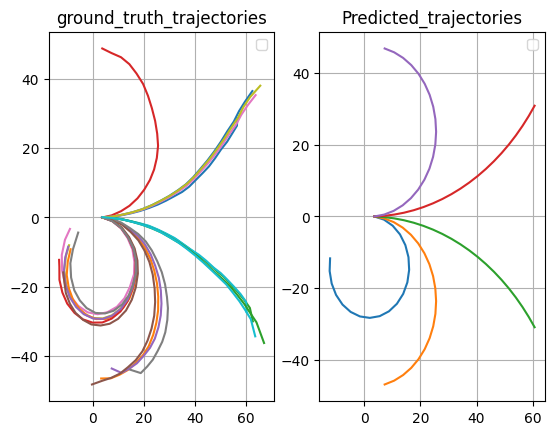

In [48]:
val_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
model.eval()
for i,j in val_loader:
    x,y = model(i)
    break
out_plots(x[0][0], j[0][0])

In [37]:
y =  y.detach().numpy()
x = x.detach().numpy()
for i in range(20):
    if y[0][0][i] >= 1:
        trajectory = x[0][0][i]
        a = trajectory[:, 0]  # Extract x positions
        b = trajectory[:, 1]
        plt.plot(a,b)
plt.show()
         